FastAI reference, for training vision functions, on a simpler dataset MINST.

In [ ]:
pip install fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

run this to get the function signature:  learn.fine_tune??

FastAi import have import * in documentation

In [2]:
from fastai.vision.all import *

In [3]:
path = untar_data(URLs.MNIST)
train_path = path / 'training'

In [4]:
mnist = DataBlock(blocks = (ImageBlock,CategoryBlock),
                 get_items = get_image_files,
                 get_y = parent_label,
                 splitter = RandomSplitter(valid_pct = 0.2, seed = 42))

dls = mnist.dataloaders(train_path)

In [43]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

**Shows information about the learner model**

In [42]:
learn.summary()

Sequential (Input shape: 64 x 3 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 14 x 14   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 7 x 7     
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                        

In [57]:
print('the number of layers that can be frozen:  %d\nnumber of currently frozen layers:  %d' % ( len(learn.opt.param_lists) , learn.opt.frozen_idx ) )

the number of layers that can be frozen:  3
number of currently frozen layers:  2


different functions for freezing



```
# freezes, up to n layers, if n is larger that number of layers, no error,
# if n >= number_of_layers, message is displayed whole network is frozen
learn.freeze_to(n)

# freezes, up to n - 1 layers, same as freeze_to(-1) or freeze_to(max_larers - 1)
learn.freeze()

# no more layers are froozen
learn.unfreeze()

```



***chatgpt explanation:***

**minimum**: This function suggests the learning rate where the loss is the absolute minimum. This might not always be the best choice, as the loss might be unstable around this point.

**steep**: This function suggests the learning rate where the loss is decreasing most steeply. This often indicates a good starting point for training, as the model is learning quickly.

**valley**: This function suggests a learning rate just before the loss starts to increase rapidly. This often corresponds to the point where the learning rate is still effective but hasn't become too high, causing the loss to diverge.

**slide**: This function suggests a learning rate based on a heuristic that looks for a point where the loss is still decreasing but is approaching a plateau. This can be useful for finding a learning rate that allows for stable training without overshooting.



***fastai source code explanation:***

from file

callback/schedule.py

valley:
    "Suggests a learning rate from the longest valley and returns its index"

slide:
      "Suggests a learning rate following an interval slide rule and returns its index"

minimum:
    "Suggests a learning rate one-tenth the minumum before divergance and returns its index"

steep:
    "Suggests a learning rate when the slope is the steepest and returns its index"



***fastai book explanation***

Our advice is to pick either:
   
- ***Minimum***: One order of magnitude less than where the minimum loss was achieved (i.e., the minimum divided by 10),
This is 'minimum' from  outputs

- The last point where the loss was clearly decreasing.
start from 'steep' forward



**Important: the minimum suggested learning rate is one order of magnitude less than where the minimum loss was achieved (i.e., the minimum divided by 10). This is different from the absolute minimum point on the chart**

Code sample, plot points and returned learning rates are not the same thing


```
        SuggestedLRs = collections.namedtuple('SuggestedLRs', nms)
        lrs, pnts = [], []
        for lr, pnt in _suggestions:
            lrs.append(lr)
            pnts.append(pnt)
        if show_plot: self.recorder.plot_lr_find(suggestions=pnts, nms=nms)
        return SuggestedLRs(*lrs)
```



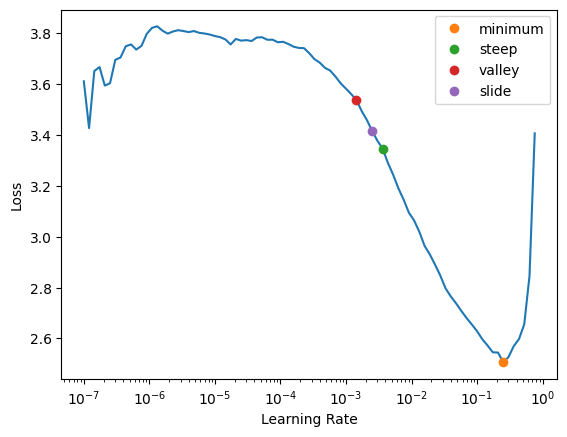

In [58]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [59]:
def format_lrs(lrs):
    descriptions = {
        'steep':   'learning rate when the slope is the steepest, \nloss is decreasing most rapidly',
        'slide':   'learning rate following an interval slide rule, \nthis could be when loss is decreasing just before the loss starts to increase rapidly',
        'minimum': '1/10th of the minimum point for the loss function, \nlargest sensible value to use for learning rate, since minimum is to high',
        'valley':  'learning rate from the longest valley, \nthis could be before the loss starts to increase rapidly',
    }

    for key, value in sorted(lrs._asdict().items(), key=lambda item: item[1]):
      print("metric: %s,  learning_rate:  %5.6f" % (key, value))
      print(descriptions[key])
      print()


In [60]:
format_lrs(lrs)

metric: valley,  learning_rate:  0.001445
learning rate from the longest valley, 
this could be before the loss starts to increase rapidly

metric: slide,  learning_rate:  0.002512
learning rate following an interval slide rule, 
this could be when loss is decreasing just before the loss starts to increase rapidly

metric: steep,  learning_rate:  0.003631
learning rate when the slope is the steepest, 
loss is decreasing most rapidly

metric: minimum,  learning_rate:  0.025119
1/10th of the minimum point for the loss function, 
largest sensible value to use for learning rate, since minimum is to high



fine tuning procedure, this traing on last layyer behind the hood, unfreezes and then trains again for the lowered learning rate.
this is good for baseline, but you can implement the same thing yourself


```
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):

    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)

```


In [66]:
learn.fine_tune(3, base_lr=0.005)

In [61]:
learn.fit_one_cycle(3, 0.005)

epoch,train_loss,valid_loss,error_rate,time
0,0.190461,0.129474,0.037917,10:56
1,0.072560,0.060675,0.017000,10:48
2,0.053552,0.039484,0.011667,10:56


During training how do learning curves for train and loss change

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

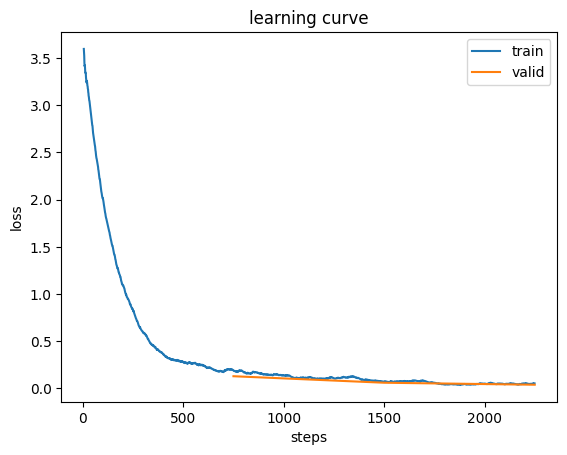

In [62]:
learn.recorder.plot_loss()

**Interpretation of multiple classes classification, what is wrongly matched**

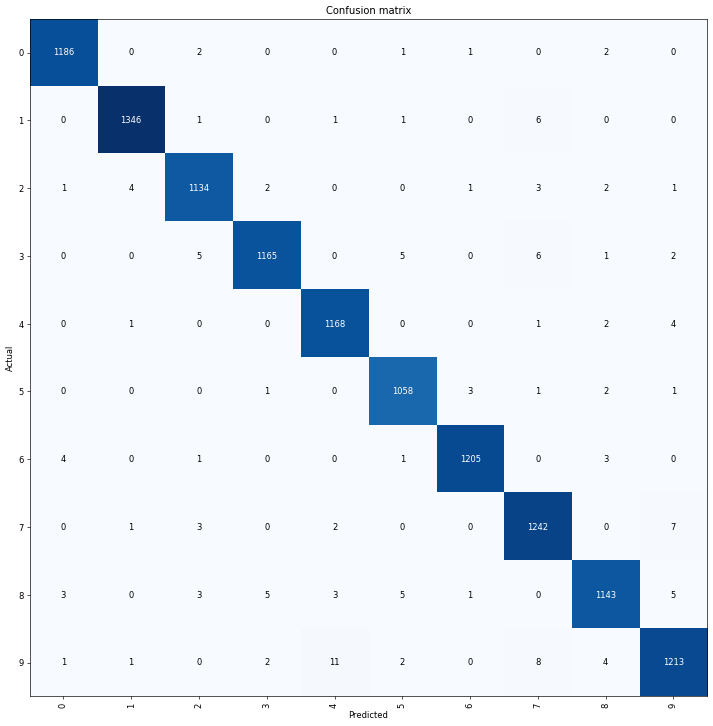

In [64]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

explanation of columns:  (actual, predicted, # occurrences)

In [79]:
interp.most_confused(min_val=5)

epoch,train_loss,valid_loss,error_rate,time
0,0.041302,0.038527,0.011417,25:02
1,0.044377,0.036831,0.010750,25:10
2,0.026539,0.036523,0.010500,25:33


[('7', '9', np.int64(10)),
 ('9', '4', np.int64(8)),
 ('7', '2', np.int64(6)),
 ('8', '3', np.int64(6)),
 ('4', '9', np.int64(5)),
 ('9', '8', np.int64(5))]

In [80]:
interp.print_classification_report()

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1192
           1       0.99      1.00      0.99      1355
           2       0.99      0.99      0.99      1148
           3       0.99      0.99      0.99      1184
           4       0.99      0.99      0.99      1176
           5       0.99      1.00      0.99      1066
           6       1.00      1.00      1.00      1214
           7       0.99      0.98      0.98      1255
           8       0.99      0.98      0.98      1168
           9       0.98      0.98      0.98      1242

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000



Visual displays of top errors in classification, here you see what is confudes because of similatiry

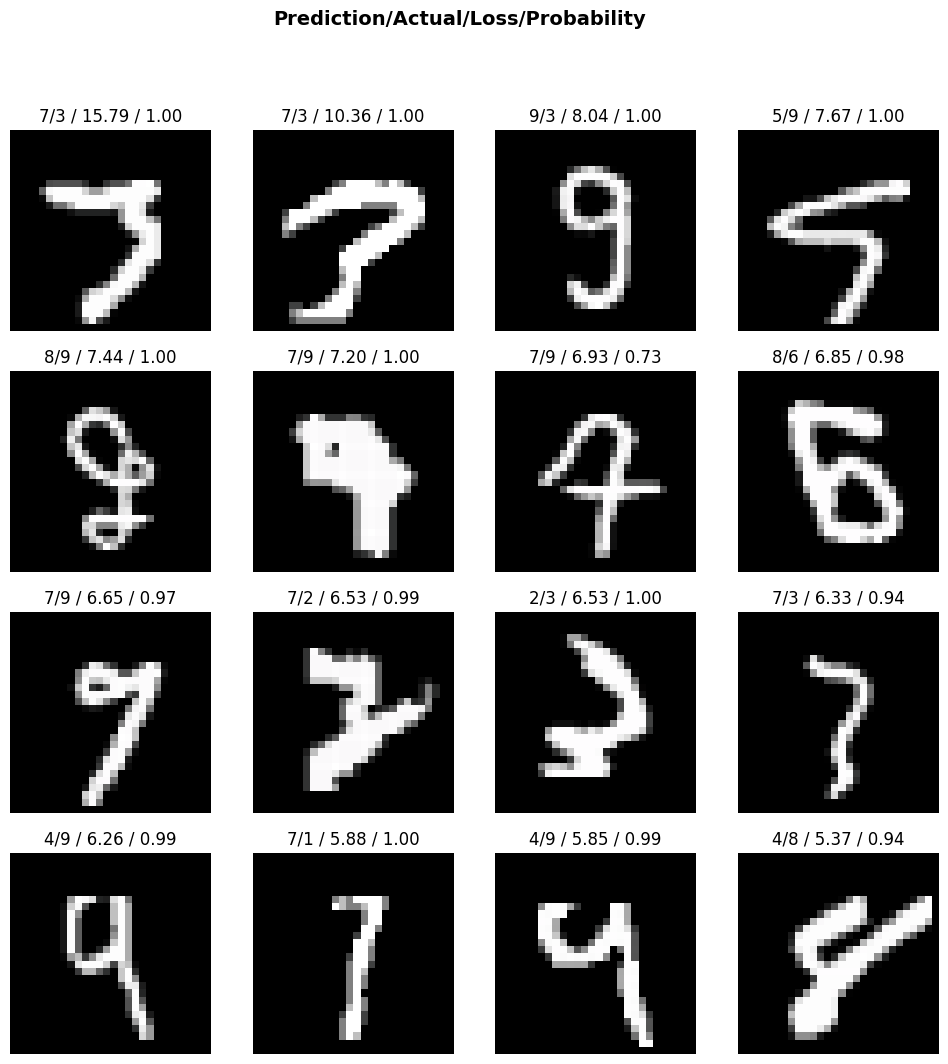

In [86]:
interp.plot_top_losses(16)

**unfreeze the model, train earlier layers**

In [69]:
learn.unfreeze()

**Learning rate procedure needs to be called again, because layers where unfrozen**

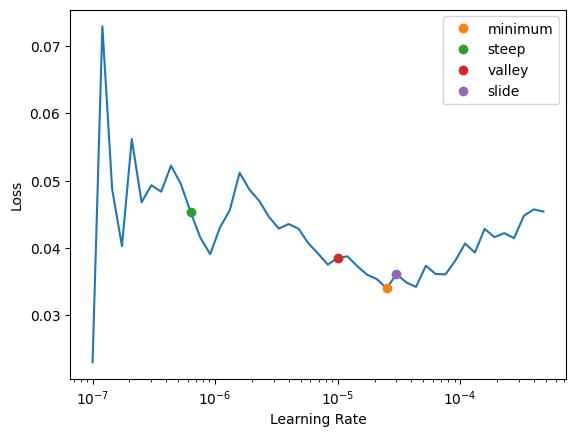

In [73]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

Early stopping is used to not train the model infinitely, but

cbs=EarlyStoppingCallback

min_delta : minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.

patience : number of epochs with no improvement after which training will be stopped.



**discriminative learning rates are used after unfreezing, earlier layers, have lower learing rate**

idea behind discriminative learning rates.
use a lower learning rate for the early layers of the neural network, and a higher learning rate for the later layers (and especially the randomly added layers).

In [77]:
learn.fit_one_cycle(12, lr_max=slice(0.000001, 0.00001), cbs=EarlyStoppingCallback(min_delta=0.001, patience=2))

epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time
0,0.041302,0.038527,0.011417,25:02
1,0.044377,0.036831,0.010750,25:10
2,0.026539,0.036523,0.010500,25:33


KeyboardInterrupt: 